# Create Baseline model for our predictor


### Load Data

In [181]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import random
import os

In [182]:

# ------- Config --------

FOLDER = "Datos"          # Carpeta con CSVs
REPORT = "profile.html"   # Salida del reporte
SAMPLE = None             # e.g., 20000 para muestrear filas si es muy grande

# 1) Cargar y unir CSVs
files = [f for f in os.listdir(FOLDER) if f.lower().endswith(".csv")]
if not files:
    raise FileNotFoundError(f"No hay CSVs en '{FOLDER}'")

dfs = []
for f in files:
    path = os.path.join(FOLDER, f)
    # dtype=object evita inferencias agresivas; luego convertimos
    df_part = pd.read_csv(path, dtype=object, low_memory=False)
    df_part["__archivo_origen"] = f
    dfs.append(df_part)

df = pd.concat(dfs, ignore_index=True)

In [183]:
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,__archivo_origen
0,2024-0339,Brisbane,Hard,32,A,20240101,300,105777,2,NaN,Grigor Dimitrov,R,191,BUL,32.6,208029,1,NaN,Holger Rune,R,188,DEN,20.6,7-6(5) 6-4,3,F,136,8,2,74,52,40,13,11,3,3,9,3,95,58,44,16,11,8,9,14,2570,8,3660,atp_matches_2024.csv
1,2024-0339,Brisbane,Hard,32,A,20240101,299,208029,1,NaN,Holger Rune,R,188,DEN,20.6,126128,NaN,NaN,Roman Safiullin,R,185,RUS,26.4,6-4 7-6(0),3,SF,97,7,4,72,48,39,11,11,1,2,5,5,66,35,31,10,11,5,7,8,3660,39,1122,atp_matches_2024.csv
2,2024-0339,Brisbane,Hard,32,A,20240101,298,105777,2,NaN,Grigor Dimitrov,R,191,BUL,32.6,111442,NaN,NaN,Jordan Thompson,R,183,AUS,29.7,6-3 7-5,3,SF,109,10,3,67,45,39,10,11,6,6,5,1,62,39,24,14,10,5,7,14,2570,55,902,atp_matches_2024.csv
3,2024-0339,Brisbane,Hard,32,A,20240101,297,208029,1,NaN,Holger Rune,R,188,DEN,20.6,105902,NaN,Q,James Duckworth,R,183,AUS,31.9,6-2 7-6(6),3,QF,105,13,0,65,36,31,17,10,1,1,5,2,77,51,31,16,10,3,5,8,3660,116,573,atp_matches_2024.csv
4,2024-0339,Brisbane,Hard,32,A,20240101,296,126128,NaN,NaN,Roman Safiullin,R,185,RUS,26.4,208286,NaN,NaN,Matteo Arnaldi,R,185,ITA,22.8,7-6(4) 6-2,3,QF,120,9,3,73,43,36,14,10,2,3,3,2,69,37,27,16,10,5,8,39,1122,44,1021,atp_matches_2024.csv


In [184]:
# Tamaño del dataset y columnas
print(df.shape)

print(df.columns)


(13174, 50)
Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points',
       '__archivo_origen'],
      dtype='object')


In [185]:
# --- BLOQUE 2: Limpieza básica y filtrado de columnas ---

# Eliminar columnas de texto que no aportan al modelo base
drop_cols = [
    'tourney_id','winner_entry','loser_entry',
    '__archivo_origen'
]
#eliminamos el tourney date para que no influya en el modelo

df = df.drop(columns=drop_cols, errors='ignore')

# Convertir todo lo posible a numérico
df = df.apply(pd.to_numeric, errors='ignore')

# Eliminar filas con NaN en variables críticas
df = df.dropna(subset=['winner_rank', 'loser_rank'])

# Crear variable binaria objetivo (1 = ganó jugador 1)
df['target'] = 1  # En tu df el "winner" siempre está identificado, luego cambiaremos


/var/folders/5x/v_n3jdfd003f7mqj3m9j1k0h0000gn/T/ipykernel_967/1684054081.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


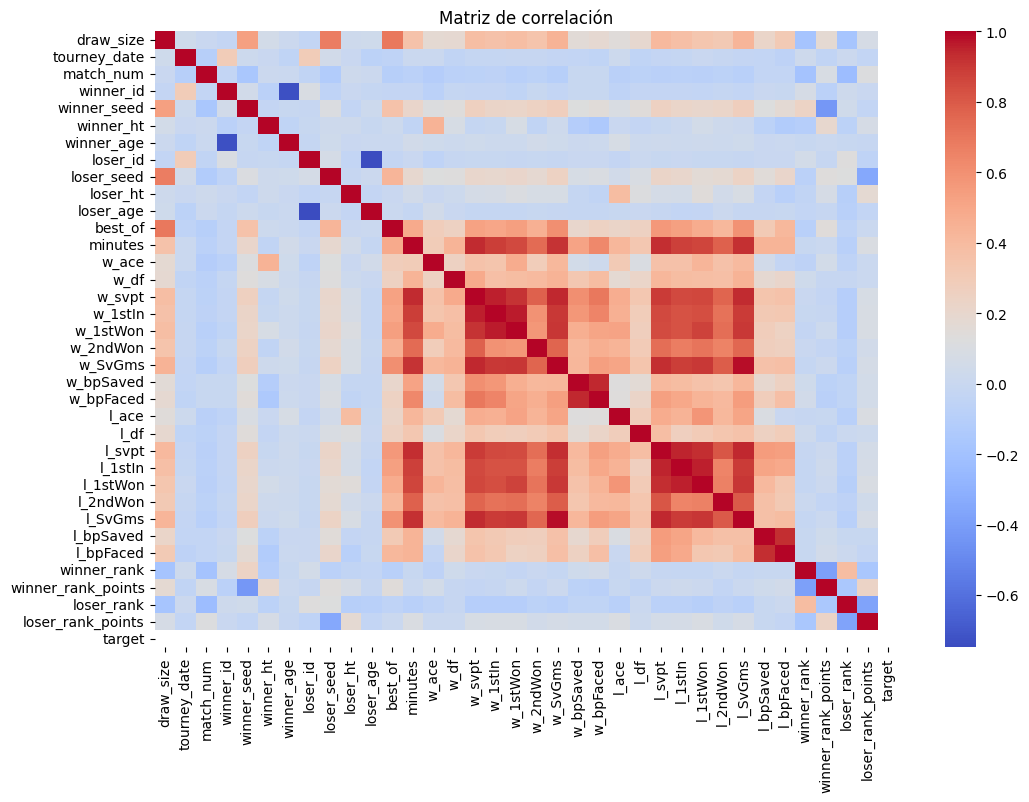

[('minutes', 'w_svpt'),
 ('minutes', 'w_SvGms'),
 ('minutes', 'l_svpt'),
 ('minutes', 'l_SvGms'),
 ('w_svpt', 'minutes'),
 ('w_svpt', 'w_1stIn'),
 ('w_svpt', 'w_1stWon'),
 ('w_svpt', 'w_SvGms'),
 ('w_svpt', 'l_SvGms'),
 ('w_1stIn', 'w_svpt'),
 ('w_1stIn', 'w_1stWon'),
 ('w_1stIn', 'w_SvGms'),
 ('w_1stWon', 'w_svpt'),
 ('w_1stWon', 'w_1stIn'),
 ('w_1stWon', 'w_SvGms'),
 ('w_SvGms', 'minutes'),
 ('w_SvGms', 'w_svpt'),
 ('w_SvGms', 'w_1stIn'),
 ('w_SvGms', 'w_1stWon'),
 ('w_SvGms', 'l_svpt'),
 ('w_SvGms', 'l_1stWon'),
 ('w_SvGms', 'l_SvGms'),
 ('w_bpSaved', 'w_bpFaced'),
 ('w_bpFaced', 'w_bpSaved'),
 ('l_svpt', 'minutes'),
 ('l_svpt', 'w_SvGms'),
 ('l_svpt', 'l_1stIn'),
 ('l_svpt', 'l_1stWon'),
 ('l_svpt', 'l_SvGms'),
 ('l_1stIn', 'l_svpt'),
 ('l_1stIn', 'l_1stWon'),
 ('l_1stWon', 'w_SvGms'),
 ('l_1stWon', 'l_svpt'),
 ('l_1stWon', 'l_1stIn'),
 ('l_1stWon', 'l_SvGms'),
 ('l_SvGms', 'minutes'),
 ('l_SvGms', 'w_svpt'),
 ('l_SvGms', 'w_SvGms'),
 ('l_SvGms', 'l_svpt'),
 ('l_SvGms', 'l_1stWon')

In [186]:
# --- BLOQUE 3: Análisis de colinealidad ---

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Matriz de correlación")
plt.show()

# Calcular pares de alta correlación (>0.9)
high_corr = [(c1, c2) for c1 in corr.columns for c2 in corr.columns
              if c1 != c2 and abs(corr.loc[c1, c2]) > 0.9]
high_corr


Eliminamos las que tienen correlación muy alta entre sí, pues podemos tener probelmas de colinealidad

In [187]:

# Elige solo numéricas
num_cols = df.select_dtypes(include=[np.number]).columns

# Matriz de correlación
corr = df[num_cols].corr().abs()

# Umbral de colinealidad (ajústalo si hace falta)
THRESH = 0.9

# Máscara de la mitad superior (excluye diagonal)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Columnas a dropear: si alguna correlación > THRESH en la fila de esa col, la marcamos
to_drop = [column for column in upper.columns if any(upper[column] > THRESH)]

print(f"Propuestas para dropear por colinealidad (>{THRESH}): {to_drop}")


Propuestas para dropear por colinealidad (>0.9): ['w_svpt', 'w_1stIn', 'w_1stWon', 'w_SvGms', 'w_bpFaced', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_SvGms', 'l_bpFaced']


In [188]:
df.columns

Index(['tourney_name', 'surface', 'draw_size', 'tourney_level', 'tourney_date',
       'match_num', 'winner_id', 'winner_seed', 'winner_name', 'winner_hand',
       'winner_ht', 'winner_ioc', 'winner_age', 'loser_id', 'loser_seed',
       'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age',
       'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df', 'w_svpt',
       'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced',
       'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
       'l_bpSaved', 'l_bpFaced', 'winner_rank', 'winner_rank_points',
       'loser_rank', 'loser_rank_points', 'target'],
      dtype='object')

Hacemos un ánalisis de colinealidad: 

-vars: 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_SvGms', 'w_bpFaced', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_SvGms', 'l_bpFaced'


- 'w_svpt': “winner serve points” — número total de puntos de servicio que jugó el ganador

- 'w_1stIn': “winner first serves in” — cuántos primeros saques del ganador entraron

- 'w_1stWon':“winner first serve points won” — cuántos puntos ganó el ganador cuando su primer saque fue exitoso

- 'w_SvGms':“winner service games” — número de juegos de servicio que ganó el ganador

- 'w_bpFaced': “winner break points faced” — cuántas oportunidades de quiebre enfrentó el ganador

- 'l_svpt': igual que w_svpt, pero para el jugador perdedor

- 'l_1stIn': igual que w_1stIn, pero para el perdedor

- 'l_1stWon': “loser first serve points won”

- 'l_SvGms': “loser service games”

- 'l_bpFaced': “loser break points faced”


Podemos ver la dependecia lineal

'w_1stWon' = 'w_svpt'+ 'w_1stIn': El número total de puntos servidos (w_svpt) ≈ número de primeros saques (w_1stIn) + segundos saques. Si además tienes w_1stWon, una de ellas será redundante.

'l_1stWon' = 'l_svpt'+ 'l_1stIn': Lo mismo pero para el perdedor

'w_SvGms' = 'l_SvGms' (igual o menos 1): En un partido ATP, el total de juegos es casi constante: si el ganador jugó 12 juegos de servicio, el perdedor también jugó 12 o uno menos. Muy correlacionadas.


'w_bpFaced' muy correlacionado con 'l_bpFaced': Cuantos más break points enfrenta uno, menos enfrenta el otro. Altamente correlacionadas (negativamente).


In [189]:
cols_to_drop = ['w_svpt', 'w_1stIn', 'w_1stWon', 'w_SvGms', 'w_bpFaced', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_SvGms', 'l_bpFaced',
                'minutes', 'w_2ndWon', 'w_bpSaved']

Quitamos columnas que se explican linealmente con otras y que son métricas post partido para que no haya leakage

In [190]:

# Dropea solo las que existan (por seguridad)
cols_present = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=cols_present)

print(f"Se dropearon {len(cols_present)} columnas.")

Se dropearon 13 columnas.


Cambianos los números nombres de las variables para que sean dos jugadores a y b, no winner y looser porque igual hay leakage. 

In [191]:
import pandas as pd

# 1) Columnas que SÍ puedes usar antes del partido
pre_player = ["id","name","hand","ht","age","ioc","seed","rank","rank_points"]
pre_context = ["surface","tourney_level","tourney_date","draw_size","round","best_of","match_num","tourney_name"]

# 2) Quitar fuga: score + estadísticas in-match (w_* / l_*)
leak_cols = [c for c in df.columns if c == "score" or c.startswith(("w_","l_"))]
df_clean = df.drop(columns=leak_cols, errors="ignore")

# 3) Construir el par A=winner, B=loser (target=1)
map_a = {f"winner_{x}": f"a_{x}" for x in pre_player}
map_b = {f"loser_{x}" : f"b_{x}" for x in pre_player}
keep_ctx = [c for c in pre_context if c in df_clean.columns]

ab_win = df_clean[ list(map_a.keys()) + list(map_b.keys()) + keep_ctx ].rename(columns={**map_a, **map_b})
ab_win["target"] = 1
ab_win["a_is_winner"] = True

# 4) Construir el par A=loser, B=winner (target=0)
map_a_rev = {f"loser_{x}" : f"a_{x}" for x in pre_player}
map_b_rev = {f"winner_{x}": f"b_{x}" for x in pre_player}

ab_lose = df_clean[ list(map_a_rev.keys()) + list(map_b_rev.keys()) + keep_ctx ].rename(columns={**map_a_rev, **map_b_rev})
ab_lose["target"] = 0
ab_lose["a_is_winner"] = False

# 5) Unir y agregar TAGs útiles para trazabilidad
ab = pd.concat([ab_win, ab_lose], ignore_index=True)

# tag: id único del partido (ajústalo si prefieres otra combinación)
if {"tourney_date","tourney_name","match_num"}.issubset(ab.columns):
    ab["pair_id"] = (ab["tourney_date"].astype(str) + "|" +
                     ab["tourney_name"].astype(str) + "|" +
                     ab["match_num"].astype(str))
else:
    ab["pair_id"] = ab.index.astype(str)

# 6) (Opcional) asegurar tipos numéricos en features
num_cols = ["a_ht","a_age","a_seed","a_rank","a_rank_points",
            "b_ht","b_age","b_seed","b_rank","b_rank_points"]
for c in [c for c in num_cols if c in ab.columns]:
    ab[c] = pd.to_numeric(ab[c], errors="coerce")

# 7) (Opcional) crear features diferenciales pre-match
if set(["a_rank","b_rank"]).issubset(ab.columns):
    ab["diff_rank"] = ab["a_rank"] - ab["b_rank"]
if set(["a_rank_points","b_rank_points"]).issubset(ab.columns):
    ab["diff_rank_points"] = ab["a_rank_points"] - ab["b_rank_points"]
if set(["a_age","b_age"]).issubset(ab.columns):
    ab["diff_age"] = ab["a_age"] - ab["b_age"]
if set(["a_ht","b_ht"]).issubset(ab.columns):
    ab["diff_ht"] = ab["a_ht"] - ab["b_ht"]

# 8) Columnas finales recomendadas para modelar (puedes ajustar)
cols_modelo = (
    [c for c in ab.columns if c.startswith(("a_","b_","diff_"))] +
    [c for c in keep_ctx if c in ab.columns] +
    ["pair_id","a_is_winner","target"]
)
ab = ab[cols_modelo]

ab.head()


,a_id,a_name,a_hand,a_ht,a_age,a_ioc,a_seed,a_rank,a_rank_points,b_id,b_name,b_hand,b_ht,b_age,b_ioc,b_seed,b_rank,b_rank_points,a_is_winner,diff_rank,diff_rank_points,diff_age,diff_ht,surface,tourney_level,tourney_date,draw_size,round,best_of,match_num,tourney_name,pair_id,a_is_winner,target
0,105777,Grigor Dimitrov,R,191.0,32.6,BUL,2.0,14.0,2570.0,208029,Holger Rune,R,188.0,20.6,DEN,1.0,8.0,3660.0,True,6.0,-1090.0,12.0,3.0,Hard,A,20240101,32,F,3,300,Brisbane,20240101|Brisbane|300,True,1
1,208029,Holger Rune,R,188.0,20.6,DEN,1.0,8.0,3660.0,126128,Roman Safiullin,R,185.0,26.4,RUS,NaN,39.0,1122.0,True,-31.0,2538.0,-5.8,3.0,Hard,A,20240101,32,SF,3,299,Brisbane,20240101|Brisbane|299,True,1
2,105777,Grigor Dimitrov,R,191.0,32.6,BUL,2.0,14.0,2570.0,111442,Jordan Thompson,R,183.0,29.7,AUS,NaN,55.0,902.0,True,-41.0,1668.0,2.9,8.0,Hard,A,20240101,32,SF,3,298,Brisbane,20240101|Brisbane|298,True,1
3,208029,Holger Rune,R,188.0,20.6,DEN,1.0,8.0,3660.0,105902,James Duckworth,R,183.0,31.9,AUS,NaN,116.0,573.0,True,-108.0,3087.0,-11.3,5.0,Hard,A,20240101,32,QF,3,297,Brisbane,20240101|Brisbane|297,True,1
4,126128,Roman Safiullin,R,185.0,26.4,RUS,NaN,39.0,1122.0,208286,Matteo Arnaldi,R,185.0,22.8,ITA,NaN,44.0,1021.0,True,-5.0,101.0,3.6,0.0,Hard,A,20240101,32,QF,3,296,Brisbane,20240101|Brisbane|296,True,1


In [192]:
ab.drop(columns=["a_is_winner","pair_id"], inplace=True, errors="ignore")

In [193]:
ab.columns

Index(['a_id', 'a_name', 'a_hand', 'a_ht', 'a_age', 'a_ioc', 'a_seed',
       'a_rank', 'a_rank_points', 'b_id', 'b_name', 'b_hand', 'b_ht', 'b_age',
       'b_ioc', 'b_seed', 'b_rank', 'b_rank_points', 'diff_rank',
       'diff_rank_points', 'diff_age', 'diff_ht', 'surface', 'tourney_level',
       'tourney_date', 'draw_size', 'round', 'best_of', 'match_num',
       'tourney_name', 'target'],
      dtype='object')

# Baseline

# Baseline "ATP Match Winner – Logistic Regression"

## Objetivo
Predecir la probabilidad de victoria en un partido ATP entre dos jugadores A vs B: entrega `P(A gana)` y `P(B gana) = 1 − P(A)`.

## Datos y etiqueta

- **Dataset A/B simétrico**: cada partido aparece en dos filas
  - A = winner → `target = 1`
  - A = loser → `target = 0`
- **Variables**: todas las pre-match disponibles (numéricas y categóricas) sin ingeniería, excluyendo columnas con fuga

## Control de fuga (leakage)

### Variables excluidas
- `score`, cualquier `w_*`, `l_*`, `winner_*`, `loser_*`, y `a_is_winner`
- **Identificadores y nombres** (`a_id`, `b_id`, `a_name`, `b_name`, `tourney_name`) no se usan como features (evita memorización)

### Prevención de fuga temporal
- Preprocesamiento (`fit`) hecho únicamente en TRAIN
- Aplicado (`transform`) en VAL/TEST
- **Split agrupado por partido** con `pair_id` (ambas filas del mismo match quedan en el mismo split)

## Preprocesamiento

- **Numéricas** → `StandardScaler`
- **Categóricas** → `OneHotEncoder(handle_unknown="ignore")`
- **NaNs** → drop de filas con faltantes en las columnas usadas (baseline estrictamente simple)

## Modelo

- Regresión logística binaria (`sklearn.LogisticRegression`, `lbfgs`, `max_iter=2000`)
- **Salida**: `predict_proba` → `P(A gana)`

## Validación

### Split de datos
- **70/15/15**: train / val / test mediante `GroupShuffleSplit` sobre `pair_id`

### Métricas
- `LogLoss`
- `ROC-AUC`
- `accuracy@0.5`
- Matriz de confusión
- `classification_report`
- (Opcional) Ajuste de umbral por Youden para maximizar accuracy o F1

## Ventajas

- Sencillo, rápido y bien calibrado
- Fuerte baseline para datos tabulares con OHE; baja varianza

## Limitaciones

- **Relación lineal** en el espacio OHE: puede quedarse corto si hay interacciones no lineales
- **No usa señales históricas** (Elo/forma/H2H), por lo que el techo de performance es moderado

## Despliegue

- Empaquetado como `Pipeline(prepro + LR)` y guardado con `joblib`
- **Inferencia**: `pipe.predict_proba(X_in)[:,1]` devuelve `P(A gana)`; `1 − ...` es `P(B gana)`

In [194]:
import os, random, numpy as np, pandas as pd

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix, classification_report

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED)

pd.set_option("display.max_columns", 120)
print("OK imports")


OK imports


In [195]:
# --- sanity: pair_id para splits agrupados ---
if "pair_id" not in ab.columns:
    if not {"tourney_date","tourney_name","match_num"}.issubset(ab.columns):
        raise ValueError("Falta 'pair_id' o columnas para construirlo (tourney_date, tourney_name, match_num).")
    ab = ab.copy()
    ab["pair_id"] = (
        ab["tourney_date"].astype(str) + "|" +
        ab["tourney_name"].astype(str) + "|" +
        ab["match_num"].astype(str)
    )

# --- columnas con fuga/metadatos que NO deben entrar al modelo ---
def is_leakage(c: str) -> bool:
    return (c == "score") or c.startswith(("w_","l_","winner_","loser_"))

META = {"target","pair_id","a_is_winner"}
IDS  = {"a_id","b_id","a_name","b_name","tourney_name"}  # no como features (riesgo de memorizar)

# --- candidatas = todas menos fuga/meta/ids ---
candidates = [c for c in ab.columns if (not is_leakage(c)) and (c not in META|IDS)]

# separar numéricas/categóricas por dtype (sin tocar los valores)
num_cols = [c for c in candidates if pd.api.types.is_numeric_dtype(ab[c])]
cat_cols = [c for c in candidates if c not in num_cols]

print(f"Features candidatas: {len(candidates)} | num: {len(num_cols)} | cat: {len(cat_cols)}")

# --- armado de X/y y drop de filas con NaN SOLO en las columnas que realmente usamos ---
X = ab[num_cols + cat_cols].copy()
y = ab["target"].astype(int).values
groups = ab["pair_id"]

before = len(X)
X = X.dropna(subset=num_cols + cat_cols)
y = y[X.index]
groups = groups.iloc[X.index]

print(f"Filas antes: {before} | después de drop por NaN: {len(X)}")


Features candidatas: 25 | num: 18 | cat: 7
Filas antes: 25972 | después de drop por NaN: 2652


Split

In [196]:
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=SEED)
train_idx, temp_idx = next(gss1.split(X, y, groups=groups))

X_train, y_train = X.iloc[train_idx], y[train_idx]
grp_temp = groups.iloc[temp_idx]
X_temp,  y_temp  = X.iloc[temp_idx], y[temp_idx]

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=SEED)  # 15/15
val_idx, test_idx = next(gss2.split(X_temp, y_temp, groups=grp_temp))
X_val, y_val   = X_temp.iloc[val_idx],  y_temp[val_idx]
X_test, y_test = X_temp.iloc[test_idx], y_temp[test_idx]

print("Train:", X_train.shape, "| Val:", X_val.shape, "| Test:", X_test.shape)


Train: (1856, 25) | Val: (398, 25) | Test: (398, 25)


In [197]:
preprocess = ColumnTransformer([
    ("num", StandardScaler(), [c for c in num_cols if c in X_train.columns]),
    ("cat", OneHotEncoder(handle_unknown="ignore"), [c for c in cat_cols if c in X_train.columns]),
], remainder="drop")  # OneHot devuelve sparse por defecto; LogisticRegression lo acepta

# Ajustar SOLO en train; transformar val/test
X_train_t = preprocess.fit_transform(X_train)
X_val_t   = preprocess.transform(X_val)
X_test_t  = preprocess.transform(X_test)

print("Shapes transformados:", X_train_t.shape, X_val_t.shape, X_test_t.shape)


Shapes transformados: (1856, 117) (398, 117) (398, 117)


In [198]:
# Logistic Regression baseline (sin trucos, buen calibrado)
lr = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    n_jobs=-1
)

lr.fit(X_train_t, y_train)

# Probabilidades en test ([:,1] = P(A gana))
probs = lr.predict_proba(X_test_t)[:,1]
pred  = (probs >= 0.5).astype(int)

print("LogLoss (test):", log_loss(y_test, np.c_[1-probs, probs]))
print("ROC-AUC (test):", roc_auc_score(y_test, probs))
print("Matriz de confusión @0.5:\n", confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, digits=3))

# Vista legible (primeras 10)
out = X_test.iloc[:10].copy()
out["P(A_gana)"] = np.round(probs[:10], 4)
out["P(B_gana)"] = np.round(1 - probs[:10], 4)
out["y_real"]    = y_test[:10]
out


LogLoss (test): 0.6130620564862683
ROC-AUC (test): 0.7291987576071312
Matriz de confusión @0.5:
 [[134  65]
 [ 65 134]]
              precision    recall  f1-score   support

           0      0.673     0.673     0.673       199
           1      0.673     0.673     0.673       199

    accuracy                          0.673       398
   macro avg      0.673     0.673     0.673       398
weighted avg      0.673     0.673     0.673       398



,a_ht,a_age,a_seed,a_rank,a_rank_points,b_ht,b_age,b_seed,b_rank,b_rank_points,diff_rank,diff_rank_points,diff_age,diff_ht,tourney_date,draw_size,best_of,match_num,a_hand,a_ioc,b_hand,b_ioc,surface,tourney_level,round,P(A_gana),P(B_gana),y_real
84,185.0,22.1,7.0,32.0,1337.0,196.0,23.5,3.0,29.0,1380.0,3.0,-43.0,-1.4,-11.0,20240108,32,3,298,R,CZE,R,USA,Hard,A,SF,0.4874,0.5126,1
248,196.0,26.2,12.0,12.0,2840.0,193.0,25.4,7.0,7.0,4025.0,5.0,-1185.0,0.8,3.0,20240115,128,5,213,R,USA,R,GRE,Hard,G,R16,0.4622,0.5378,1
258,198.0,26.7,6.0,6.0,4275.0,183.0,20.6,2.0,2.0,8855.0,4.0,-4580.0,6.1,15.0,20240115,128,5,223,R,GER,R,ESP,Hard,G,QF,0.2619,0.7381,1
321,193.0,21.3,3.0,16.0,1965.0,183.0,29.7,7.0,44.0,1022.0,-28.0,943.0,-8.4,10.0,20240205,32,3,295,L,USA,R,AUS,Hard,A,QF,0.6063,0.3937,1
401,201.0,28.3,3.0,21.0,1810.0,196.0,24.5,6.0,27.0,1465.0,-6.0,345.0,3.8,5.0,20240212,32,3,296,R,CHI,R,ARG,Clay,A,QF,0.6027,0.3973,1
640,185.0,22.3,32.0,32.0,1260.0,193.0,25.5,11.0,11.0,3170.0,21.0,-1910.0,-3.2,-8.0,20240304,128,3,289,R,CZE,R,GRE,Hard,M,R16,0.3509,0.6491,1
651,188.0,20.8,7.0,7.0,3720.0,185.0,22.0,26.0,26.0,1480.0,-19.0,2240.0,-1.2,3.0,20240304,128,3,278,R,DEN,R,ITA,Hard,M,R32,0.5451,0.4549,1
724,191.0,22.5,2.0,3.0,8310.0,191.0,32.8,11.0,12.0,2935.0,-9.0,5375.0,-10.3,0.0,20240318,128,3,300,R,ITA,R,BUL,Hard,M,F,0.7224,0.2776,1
725,191.0,32.8,11.0,12.0,2935.0,198.0,26.9,4.0,5.0,5060.0,7.0,-2125.0,5.9,-7.0,20240318,128,3,299,R,BUL,R,GER,Hard,M,SF,0.4323,0.5677,1
731,183.0,20.8,1.0,2.0,8805.0,185.0,22.0,23.0,24.0,1520.0,-22.0,7285.0,-1.2,-2.0,20240318,128,3,293,R,ESP,R,ITA,Hard,M,R16,0.8583,0.1417,1


# Red nueronal básica

# Ficha técnica del modelo (ATP Match Winner – NN)

## Objetivo
Predecir la probabilidad de victoria entre dos jugadores (A vs B) en un partido ATP. La red devuelve P(A gana) y P(B gana).

## Construcción del dataset (pairing A vs B)

- **Emparejado simétrico**: cada partido se duplica en dos filas:
  - Fila positiva: A = winner, B = loser, `y = 1`.
  - Fila negativa: A = loser, B = winner, `y = 0`.
- **Features diferenciales (A − B)** para evitar colinealidad y asegurar simetría:
  - Pre-match: `diff_rank`, `diff_rank_points`, `diff_seed`, `diff_ht`, `diff_age`.
  - (Opcional, desactivado para evitar fuga): estadísticas in-match como `diff_1stIn`, `diff_1stWon`, `diff_bpFaced`, etc.
- **Categóricas de contexto** (no se restan): `surface`, `tourney_level`.
- (Opcional) **indicadores binarios** entre jugadores: `same_hand`, `same_ioc`.

**Motivación del pairing**: garantiza ambas clases (0/1), mantiene el problema simétrico (intercambiar A↔B invierte la etiqueta) y simplifica la interpretación de coeficientes y pesos.

## Preprocesamiento

- Numéricas → `StandardScaler` (media 0, var 1).
- Categóricas → `OneHotEncoder(handle_unknown="ignore")`.
- Transformación hecha con `ColumnTransformer`, ajustada solo en train y aplicada a val/test.
- **Supuesto**: el `df` ya no contiene NaNs (si aparecieran, numéricas → media; categóricas → drop de filas con NaN).

## Arquitectura de la red (Keras, `Sequential`)

- **Entrada**: vector denso resultante del preprocesamiento.
- **Capa 1**: `Dense(128, activation='relu')`
- **Dropout**: `0.30`
- **Capa 2**: `Dense(64, activation='relu')`
- **Dropout**: `0.20`
- **Salida**: `Dense(2, activation='softmax')` → prob. por clase `[P(B), P(A)]`.
- **Regularización L2**: ligera (`kernel_regularizer=l2(1e-6)`) en capas densas.

### Justificación del diseño

- 128→64 neuronas: capacidad suficiente para relaciones no lineales en datos tabulares con decenas-centenas de features (tras one-hot), evitando sobreparametrización.
- ReLU por convergencia estable/rápida en tabular.
- Dropout + L2 para controlar sobreajuste (especialmente útil con features derivadas y one-hot).
- Softmax (2) para probabilidades bien calibradas por clase.

## Función de pérdida, optimizador y batching

- **Loss**: `sparse_categorical_crossentropy` (clases {0,1} sin one-hot).
- **Optimizador**: `Adam(learning_rate=1e-3)`.
- **Esquema de descenso**: mini-batch gradient descent con `batch_size=256`. (No es full batch; mini-batch ofrece mejor estabilidad/velocidad práctica.)

## Entrenamiento y callbacks

- **División**: 70% train, 15% val, 15% test (via train/val/test splits).
- **EarlyStopping**: `monitor='val_loss'`, `patience=10`, `restore_best_weights=True`.
- **ReduceLROnPlateau**: reduce LR (×0.5) al estancarse `val_loss` (patience=4).
- **Épocas**: hasta 100 (corta antes con EarlyStopping).
- **Seed**: 42 para reproducibilidad (Python/NumPy/TF).

## Métricas y gráficos

- **Métricas principales**: `accuracy` durante entrenamiento; en evaluación adicional: ROC-AUC, log loss y matriz de clasificación binaria vía scikit-learn.
- **Gráficas**:
  - Loss (train vs val) por época y línea horizontal con test loss final.
  - Error (1−accuracy) para train/val y valor final de test.
- **Interpretación típica** (ejemplo de tu corrida): `train/val loss` decrecientes y cercanas, con test loss en línea con `val loss` → modelo estable y sin sobreajuste marcado.

## Supuestos y buenas prácticas

- Para predicción previa al partido, usar solo pre-match (como está configurado) para evitar data leakage.
- Si hay desbalance de clases (no debería con pairing), considerar `class_weight='balanced'`.
- Guardar `preprocess` y `model` para inferencia consistente en producción.

## Hiperparámetros clave (fáciles de ajustar)

- `learning_rate` (p. ej., `5e-4` si oscilan las curvas).
- `dropout` (`0.30/0.20` → subir si hay sobreajuste, bajar si underfitting).
- `l2_reg` (`1e-6` → probar `1e-5` o `1e-4` si hace falta más regularización).
- Profundidad/ancho: añadir `Dense(32)` extra si el modelo se queda corto.

In [199]:
# ============================
# 1) Drop de FILAS con NaN en categóricas (NO se borran columnas)
# ============================
# Identifica categóricas
cat_cols = ab.select_dtypes(include=['object', 'category']).columns.tolist()
before = len(ab)
ab = ab.dropna(subset=cat_cols).copy()
print(f"Filas dropeadas por NaN en categóricas: {before - len(ab)}")
print(f"Total filas tras drop: {len(ab)}")

# (Opcional) Asegura que no queden inf/-inf en numéricas; se convertirán a NaN y se imputarán
num_cols_all =ab.select_dtypes(include=[np.number]).columns
ab[num_cols_all] = ab[num_cols_all].replace([np.inf, -np.inf], np.nan)

Filas dropeadas por NaN en categóricas: 72
Total filas tras drop: 25900


In [200]:

num_cols = [c for c in ab.select_dtypes(include=[np.number]).columns if c != 'target']
ab[num_cols] = ab[num_cols].replace([np.inf, -np.inf], np.nan)

# Media por columna (Series: col -> media)
col_means = ab[num_cols].mean()

# Imputa NaN de cada columna con SU propia media
ab[num_cols] = ab[num_cols].fillna(col_means)

# (Opcional) ver qué media usaste por columna
print(col_means.to_string())

a_id                1.386483e+05
a_ht                1.871731e+02
a_age               2.690288e+01
a_seed              8.361089e+00
a_rank              8.675336e+01
a_rank_points       1.574548e+03
b_id                1.386483e+05
b_ht                1.871731e+02
b_age               2.690288e+01
b_seed              8.361089e+00
b_rank              8.675336e+01
b_rank_points       1.574548e+03
diff_rank           0.000000e+00
diff_rank_points    0.000000e+00
diff_age           -3.511563e-17
diff_ht             0.000000e+00
tourney_date        2.022322e+07
draw_size           6.236710e+01
best_of             3.378224e+00
match_num           2.549765e+02


In [201]:
# =========================================
# NN para P(A gana) con pairing A vs B (softmax)
# =========================================
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, log_loss, accuracy_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, Sequential
from tensorflow.keras.regularizers import l2

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)



In [202]:
# =========================================
# NN para P(A gana) con pairing A vs B (softmax)
# =========================================
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, log_loss, accuracy_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, Sequential
from tensorflow.keras.regularizers import l2

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


In [203]:
# Definimos bases pre-match que existan en tu df (winner_* y loser_*):
PREMATCH_NUM = ["rank", "rank_points", "seed", "ht", "age"]  # NO usar nada in-match (w_/l_...)

def has_pair(df, base):
    return ("winner_"+base in df.columns) and ("loser_"+base in df.columns)

def build_pair_df(df, cat_keep=("surface","tourney_level","round","tourney_date","tourney_name"),
                  id_cols=("tourney_date","tourney_name","round","match_num")):
    cat_keep = [c for c in cat_keep if c in df.columns]
    bases = [b for b in PREMATCH_NUM if has_pair(df, b)]
    has_hands = ("winner_hand" in df.columns) and ("loser_hand" in df.columns)
    has_ioc   = ("winner_ioc"  in df.columns) and ("loser_ioc"  in df.columns)

    rows = []
    for _, r in df.iterrows():
        # --- fila positiva (A = winner)
        pos = {f"diff_{b}": r["winner_"+b] - r["loser_"+b] for b in bases}
        for c in cat_keep: pos[c] = r[c]
        if has_hands: pos["same_hand"] = int(r["winner_hand"] == r["loser_hand"])
        if has_ioc:   pos["same_ioc"]  = int(r["winner_ioc"]  == r["loser_ioc"])
        pos["target"] = 1

        # Pair key simétrica (mismo id para positiva/negativa)
        # usa fecha+torneo+round+match_num si existe; de lo contrario, fecha + jugadores ordenados
        if set(id_cols).issubset(df.columns):
            pos["pair_id"] = f"{r[id_cols[0]]}|{r[id_cols[1]]}|{r[id_cols[2]]}|{r[id_cols[3]]}"
        else:
            wn = str(r.get("winner_name","?")); ln = str(r.get("loser_name","?"))
            a,b = sorted([wn, ln])
            pos["pair_id"] = f"{r.get('tourney_date','?')}|{r.get('tourney_name','?')}|{a}|{b}"

        rows.append(pos)

        # --- fila negativa (A = loser) — invierte difs y misma pair_id
        neg = {k: (-v if k.startswith("diff_") else v) for k,v in pos.items() if k not in {"target","pair_id"}}
        neg["target"]  = 0
        neg["pair_id"] = pos["pair_id"]
        rows.append(neg)

    out = pd.DataFrame(rows)
    return out

# df = ...  # <- tu dataframe crudo de partidos (winner/loser)
df_pair = build_pair_df(df)
print("df_pair shape:", df_pair.shape)
df_pair.head()


df_pair shape: (25972, 14)


,diff_rank,diff_rank_points,diff_seed,diff_ht,diff_age,surface,tourney_level,round,tourney_date,tourney_name,same_hand,same_ioc,target,pair_id
0,6.0,-1090.0,1.0,3.0,12.0,Hard,A,F,20240101,Brisbane,1,0,1,20240101|Brisbane|F|300
1,-6.0,1090.0,-1.0,-3.0,-12.0,Hard,A,F,20240101,Brisbane,1,0,0,20240101|Brisbane|F|300
2,-31.0,2538.0,NaN,3.0,-5.8,Hard,A,SF,20240101,Brisbane,1,0,1,20240101|Brisbane|SF|299
3,31.0,-2538.0,NaN,-3.0,5.8,Hard,A,SF,20240101,Brisbane,1,0,0,20240101|Brisbane|SF|299
4,-41.0,1668.0,NaN,8.0,2.9,Hard,A,SF,20240101,Brisbane,1,0,1,20240101|Brisbane|SF|298


In [204]:
y = df_pair["target"].astype(int).values
X = df_pair.drop(columns=["target"])
groups = df_pair["pair_id"]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()            # diff_* + same_*
cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()  # surface, level, round, fechas si string

# No usamos pair_id como feature
if "pair_id" in num_cols:  num_cols.remove("pair_id")
if "pair_id" in cat_cols:  cat_cols.remove("pair_id")
X = X.drop(columns=["pair_id"])

print(f"Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)} | X shape: {X.shape}")


Numéricas: 8 | Categóricas: 4 | X shape: (25972, 12)


In [205]:
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=SEED)
train_idx, temp_idx = next(gss1.split(X, y, groups=groups))

X_train, y_train = X.iloc[train_idx], y[train_idx]
grp_temp = groups.iloc[temp_idx]
X_temp,  y_temp  = X.iloc[temp_idx], y[temp_idx]

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=SEED)  # 15/15
val_idx, test_idx = next(gss2.split(X_temp, y_temp, groups=grp_temp))
X_val, y_val   = X_temp.iloc[val_idx],  y_temp[val_idx]
X_test, y_test = X_temp.iloc[test_idx], y_temp[test_idx]

print("Train:", X_train.shape, "| Val:", X_val.shape, "| Test:", X_test.shape)


Train: (18180, 12) | Val: (3896, 12) | Test: (3896, 12)


In [206]:
def make_ohe_dense():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >=1.2
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn <1.2

numeric_tf = (
    "num",
    Pipeline(steps=[
        ("imp", SimpleImputer(strategy="median")),        # imputación numérica
        ("sc",  StandardScaler())
    ]),
    [c for c in num_cols if c in X_train.columns]
)

categorical_tf = (
    "cat",
    Pipeline(steps=[
        ("imp", SimpleImputer(strategy="most_frequent")), # imputación categórica
        ("ohe", make_ohe_dense())
    ]),
    [c for c in cat_cols if c in X_train.columns]
)

preprocess = ColumnTransformer(
    transformers=[numeric_tf, categorical_tf],
    remainder="drop"
)

X_train_p = preprocess.fit_transform(X_train)  # <- fit SOLO en train
X_val_p   = preprocess.transform(X_val)
X_test_p  = preprocess.transform(X_test)

input_dim = X_train_p.shape[1]
print("input_dim:", input_dim)


input_dim: 401


In [207]:
def build_model(input_dim, lr=1e-3, l2_reg=1e-6, d1=0.30, d2=0.20):
    reg = l2(l2_reg)
    m = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu", kernel_regularizer=reg),
        layers.Dropout(d1),
        layers.Dense(64, activation="relu",  kernel_regularizer=reg),
        layers.Dropout(d2),
        layers.Dense(2, activation="softmax")  # [P(B), P(A)]
    ])
    m.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return m

model = build_model(input_dim=input_dim, lr=1e-3, l2_reg=1e-6, d1=0.30, d2=0.20)
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,842 (233.76 KB)

 Trainable params: 59,842 (233.76 KB)

 Non-trainable params: 0 (0.00 B)

In [208]:
cbs = [
    callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1)
]

history = model.fit(
    X_train_p, y_train,
    validation_data=(X_val_p, y_val),
    epochs=150,
    batch_size=256,
    callbacks=cbs,
    verbose=1
)


Epoch 1/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6248 - loss: 0.6434 - val_accuracy: 0.6368 - val_loss: 0.6264 - learning_rate: 0.0010
Epoch 2/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6358 - loss: 0.6301 - val_accuracy: 0.6412 - val_loss: 0.6239 - learning_rate: 0.0010
Epoch 3/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6402 - loss: 0.6273 - val_accuracy: 0.6409 - val_loss: 0.6223 - learning_rate: 0.0010
Epoch 4/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6430 - loss: 0.6239 - val_accuracy: 0.6389 - val_loss: 0.6208 - learning_rate: 0.0010
Epoch 5/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6468 - loss: 0.6204 - val_accuracy: 0.6419 - val_loss: 0.6204 - learning_rate: 0.0010
Epoch 6/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6483 - loss: 0.6187 - val_accuracy: 0.6396 - val_loss: 0.6203 - learning_rate: 0.0010
Epoch 7/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6509 - loss: 0.6159 - val_acc

              precision    recall  f1-score   support

           0      0.635     0.639     0.637      1948
           1      0.637     0.633     0.635      1948

    accuracy                          0.636      3896
   macro avg      0.636     0.636     0.636      3896
weighted avg      0.636     0.636     0.636      3896

ROC-AUC (A positiva): 0.6972106388271655
LogLoss: 0.6265074865457421


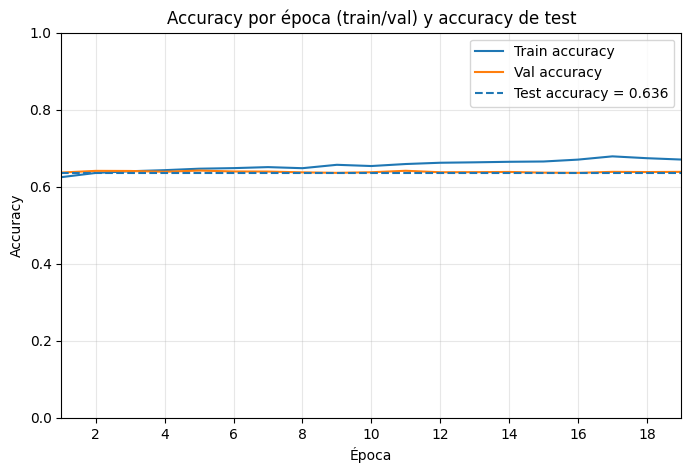

In [209]:
# Probabilidades (softmax) y P(A)
probs = model.predict(X_test_p, verbose=0)   # shape (n,2)
pA    = probs[:, 1]                          # P(A gana)

# Umbral fijo 0.5 como pediste
y_pred = (pA >= 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC (A positiva):", roc_auc_score(y_test, pA))
print("LogLoss:", log_loss(y_test, probs))

# ---- Accuracy por época (train/val) + línea test ----
H = history.history
train_key = "accuracy" if "accuracy" in H else ("acc" if "acc" in H else None)
val_key   = "val_accuracy" if "val_accuracy" in H else ("val_acc" if "val_acc" in H else None)

import matplotlib.pyplot as plt
train_acc = np.array(H[train_key]); val_acc = np.array(H[val_key])
epochs = np.arange(1, len(train_acc)+1)
test_acc = accuracy_score(y_test, y_pred)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label="Train accuracy")
plt.plot(epochs, val_acc,   label="Val accuracy")
plt.axhline(test_acc, linestyle="--", linewidth=1.5, label=f"Test accuracy = {test_acc:.3f}")
plt.title("Accuracy por época (train/val) y accuracy de test")
plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.xlim(1, len(epochs)); plt.ylim(0,1)
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


# Diagnóstico del Modelo de Predicción de Tenis

Se ve así por tres razones normales en este setup:

## 1. La señal pre-match es limitada
Con pairing simétrico y sin features históricas (Elo/forma/H2H), lo típico es ~0.60–0.66. El modelo aprende rápido lo "obvio" (ranking/seed/surface) y se estanca: por eso las curvas de train/val van casi planas y pegadas.

## 2. Accuracy no es sensible a mejoras pequeñas
Aunque la pérdida (logloss) baje y las probabilidades se calibren mejor, el accuracy apenas sube si muchos casos quedan cerca de 0.5. Por eso la línea de test (0.636) y las curvas por época son casi horizontales. Mira **AUC** y **logloss** para detectar mejoras reales.

## 3. Capacidad ≠ cuello de botella
Tu MLP (128–64 ReLU + dropout + L2) tiene capacidad suficiente para este tabular con OHE; más capas/épocas no cambian mucho si no hay más señal. El ligero gap train>val indica algo de varianza pero no grave.

---

## Qué haría (en orden de impacto)

### Añadir señal
- `elo_diff` (y Elo por superficie)
- Forma reciente (win% últimos N, media Elo últimos N)
- H2H simple

Eso suele subir AUC varios puntos; ya viste que Elo mejoró al HGB.

### Medir lo correcto
Traza **logloss** y **AUC** por época (además de accuracy). Si caen, vas bien aunque el accuracy no se mueva mucho.

### Probar árbol/tabular
HistGradientBoosting/XGBoost para comparar: en tabular suele ganar a la MLP con estas features.

### Ajustes menores
- Baja `dropout` si sospechas underfitting (p. ej. 0.2/0.1)
- Prueba `batch_size=128`
- O un LR un poco menor (`5e-4`) con `ReduceLROnPlateau`

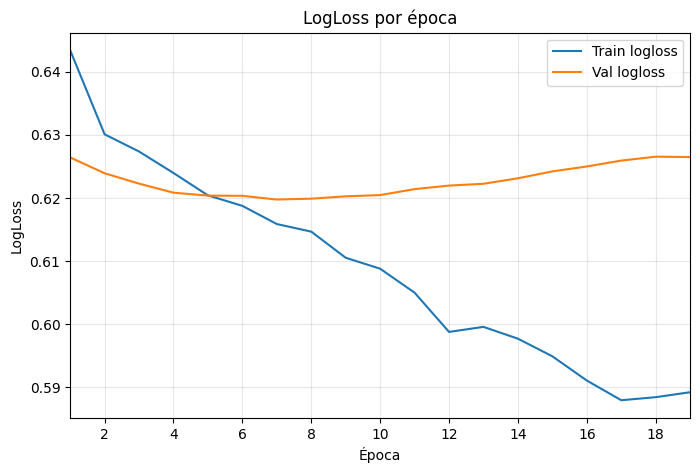

In [210]:
import numpy as np
import matplotlib.pyplot as plt

H = history.history  # devuelto por model.fit(...)
loss_tr = np.array(H["loss"])
loss_va = np.array(H["val_loss"])
epochs  = np.arange(1, len(loss_tr)+1)

plt.figure(figsize=(8,5))
plt.plot(epochs, loss_tr, label="Train logloss")
plt.plot(epochs, loss_va, label="Val logloss")
plt.title("LogLoss por época")
plt.xlabel("Época"); plt.ylabel("LogLoss")
plt.xlim(1, len(epochs))
plt.grid(True, alpha=0.3); plt.legend(); plt.show()
